# Kredi Kartı Dolandırıcılığı Tespiti

Önceki egzersizler, bir sinir ağının tüm farklı bileşenlerine daha yakından bakmanızı sağladı:
* sıralı (sequential) yoğun (Dense) bir Sinir Ağı mimarisi,
* derleme (compilation) yöntemi,
* modelin eğitilmesi (fitting).

Şimdi **çok fazla veri içeren** gerçek hayat bir veri seti üzerinde çalışalım!

**Veri seti: `Kredi Kartı İşlemleri (Credit Card Transactions)`**

Bu açık uçlu challenge’da, **kredi kartı işlemlerinden elde edilmiş verilerle** çalışacaksınız.

Bu veriler **hassas** olduğu için, toplam 31 sütundan yalnızca 3’ü bilinmektedir; geri kalanlar verileri **anonimleştirmek** amacıyla dönüştürülmüştür (aslında bunlar, orijinal verilerin **PCA projeksiyonlarıdır**).

Bilinen 3 sütun şunlardır:

* `TIME`: İşlemin, veri setindeki ilk işleme göre geçen süresi  
* `AMOUNT`: İşlem tutarı  
* `CLASS` (hedef değişkenimiz):
    * `0 : geçerli işlem`
    * `1 : sahte (fraud) işlem`

❓ **Soru** ❓ Veri setini indirerek başlayın:
* Kaggle üzerinden: [buradan](https://www.kaggle.com/mlg-ulb/creditcardfraud)
* veya bizim URL’mizden: [buradan](https://d32aokrjazspmn.cloudfront.net/materials/creditcard.csv)

Veriyi yükleyerek `X` ve `y` değişkenlerini oluşturun.

In [1]:
# !pip install imblearn

In [2]:
# Linear Algebra
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

# Imbalanced Classes
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# TensorFlow Keras
import keras
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

2026-01-22 10:45:16.952974: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 10:45:16.993554: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-22 10:45:17.311710: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-22 10:45:17.650506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-22 10:45:17.960194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [3]:
df = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/creditcard.csv")

In [4]:
X = df.drop(columns=['Class'], axis=1).values
y = df['Class'].values

## 1. Sınıfların yeniden dengelenmesi

In [5]:
# Sınıf dengesini kontrol edelim
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
Name: proportion, dtype: float64

☝️ Bu `fraud detection` (sahtekârlık tespiti) challenge’ında **sınıflar aşırı derecede dengesizdir**:
* %99.8 normal işlemler
* %0.2 sahte (fraud) işlemler

**Ciddi yeniden dengeleme (rebalancing) stratejileri uygulamazsak sahtekârlık vakalarını tespit edemeyiz!**

❓ **Soru** ❓
1. **Önce**, veri setinizden üç ayrı bölme oluşturun: `Train / Val / Test`.  
   Doğrulama (validation) ve test setlerinin **dengesiz** kalması son derece önemlidir; böylece modeli değerlendirirken gerçek koşullar korunur ve veri sızıntısı (data leakage) oluşmaz. Test setinizi bu notebook’un **en son hücresine kadar saklayın**!

&nbsp;

2. **İkinci olarak**, yalnızca eğitim setinizi (training set) yeniden dengeleyin. Birçok seçeneğiniz var:

- Azınlık sınıfını rastgele oversample etmek (düz NumPy fonksiyonlarıyla).  
  *(En iyi seçenek değildir; çünkü satırları kopyalayarak veri sızıntısı yaratır.)*
- <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">**`Synthetic Minority Oversampling Technique - SMOTE`**</a> kullanarak, mevcut gözlemleri ağırlıklandırıp yeni veri noktaları üretmek
- Buna ek olarak, çoğunluk sınıfını bir miktar küçültmek için  
  <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">**`RandomUnderSampler`**</a> da deneyebilirsiniz

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [8]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [9]:
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"Eğitim setinde {pd.Series(y_train).value_counts()[1]} dolandırıcılık işlemi var")
print(f"Doğrulama setinde {pd.Series(y_val).value_counts()[1]} dolandırıcılık işlemi var")
print(f"Test setinde {pd.Series(y_test).value_counts()[1]} dolandırıcılık işlemi var")

240
103
149
----------------------------------------------------------------------------------------------------
Eğitim setinde 240 dolandırıcılık işlemi var
Doğrulama setinde 103 dolandırıcılık işlemi var
Test setinde 149 dolandırıcılık işlemi var


In [10]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [11]:
from sklearn import set_config;  set_config(display='diagram')

# İki stratejiyi ardışık bağlama
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [12]:
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56146, 30)
y_train_resampled.shape = (56146,)


In [13]:
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:30]
y_train_resampled = stacked_resampled_data[:,-1]

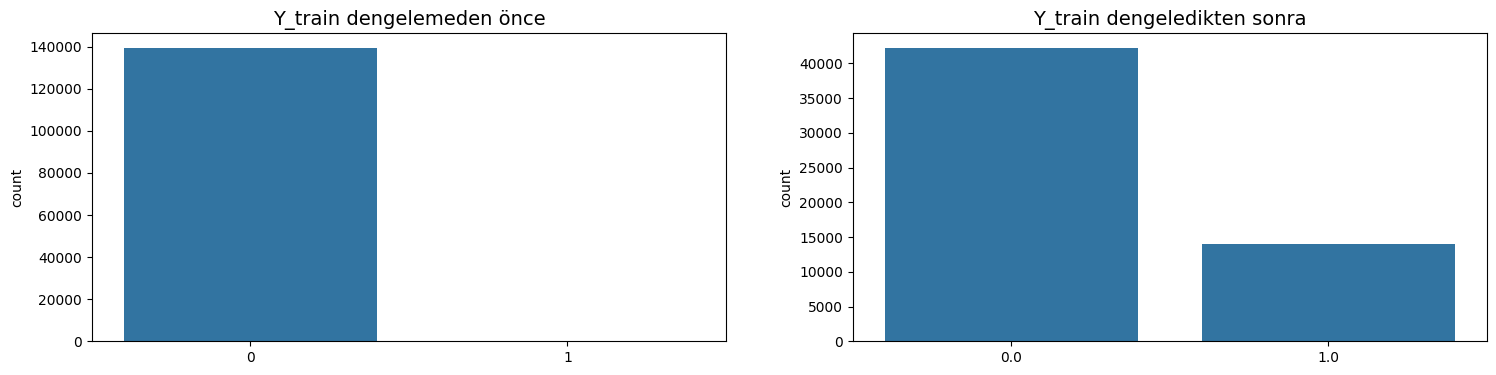

In [14]:
# çizim
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Sınıfları dengelemeden önce'''

sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Y_train dengelemeden önce', fontsize=14)

''' Sınıfları dengeledikten sonra'''

sns.countplot(x=y_train_resampled, ax=ax[1])
ax[1].set_title('Y_train dengeledikten sonra', fontsize=14);

In [15]:
print(X_train_resampled.shape)
print(X_val.shape)

(56146, 30)
(59810, 30)


## 2. Sinir Ağı yinelemeleri

Sınıflarınızı yeniden dengelediğinize göre, test puanınızı optimize etmek için bir sinir ağı uyarlayın. Aşağıdaki ipuçlarını kullanmaktan çekinmeyin:

- Girişlerinizi normalleştirin!
    - Modelinizdeki ön işlemeyi “boru hattı” haline getirmek için tercihen model içinde bir [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) katmanı kullanın. 
    - Veya modelinizin dışında sklearn'in [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) öğesini kullanın, `X_train`, `X_val` ve `X_test` öğelerini uygulayın.
- Modelinizi aşırı uyumlu hale getirin, ardından aşağıdakileri kullanarak düzenleyin:
- Erken Durdurma kriterleri
- [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) katmanları
    - veya [`düzenleyiciler`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) katmanları
- 🚨 İzlemek istediğiniz metrikleri ve kullanmak istediğiniz kayıp fonksiyonunu dikkatlice düşünün!

In [16]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [17]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision

def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

### 🧪 Kodunu Test Et

Orijinal dengesiz veri kümesinin (`X_test`, `y_test`) temsil edici bir örneğinde gerçek test performansınızın altında kalan sonuçları `precision` ve `recall` değişkenlerine kaydedin.

In [20]:
model = init_model()

In [21]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # Dolandırıcılık işlemlerini gerçekten tespit etmek istiyoruz!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Dolandırıcılık işlemlerini içerme şansı elde etmek için yeterince büyük
                    callbacks=[es], shuffle=True)

Epoch 1/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5362 - prc: 0.6402 - precision: 0.5507 - recall: 0.5554 - val_loss: 0.1920 - val_prc: 0.5421 - val_precision: 0.7363 - val_recall: 0.6505
Epoch 2/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2558 - prc: 0.9044 - precision: 0.9473 - recall: 0.7083 - val_loss: 0.0337 - val_prc: 0.5750 - val_precision: 0.6404 - val_recall: 0.7087
Epoch 3/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1686 - prc: 0.9494 - precision: 0.9745 - recall: 0.7869 - val_loss: 0.0203 - val_prc: 0.6151 - val_precision: 0.5571 - val_recall: 0.7573
Epoch 4/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1357 - prc: 0.9641 - precision: 0.9821 - recall: 0.8173 - val_loss: 0.0195 - val_prc: 0.6169 - val_precision: 0.3951 - val_recall: 0.7864
Epoch 5/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1201 - prc: 0.9709 - precision: 0.9830 - recall: 0.8348 - val_loss: 0.0206 - val_prc: 0.6327 - val_precision: 0.2971 - val_recall: 0.

In [22]:
def plot_loss_precision_recall_curve(history):

    fig, ax =plt.subplots(1, 3, figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14)
    ax[1].set_ylabel('Recall', fontsize=14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)


    # --- PRECISION


    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize=18)
    ax[2].set_xlabel('Epoch', fontsize=14)
    ax[2].set_ylabel('Precision', fontsize=14)
    ax[2].legend(['Train', 'Val'], loc='lower right')
    ax[2].grid(axis="x", linewidth=0.5)
    ax[2].grid(axis="y", linewidth=0.5)

    plt.show()

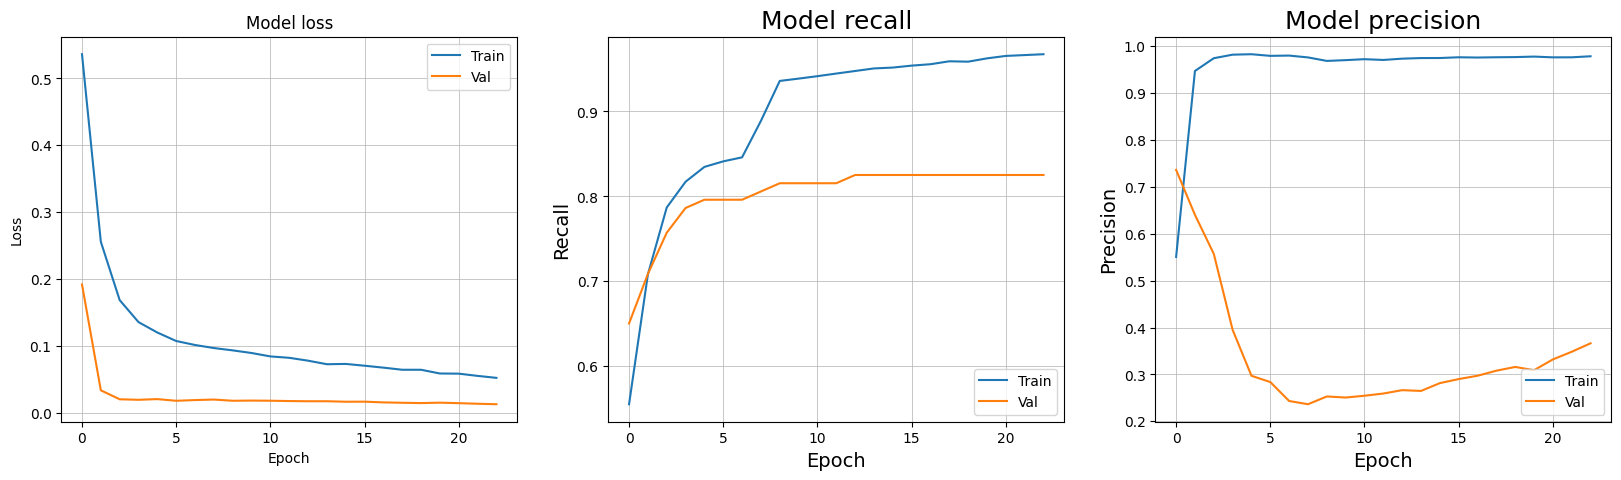

In [23]:
plot_loss_precision_recall_curve(history)

In [25]:
from nbresult import ChallengeResult

result = ChallengeResult('solution',
    precision=precision,
    recall=recall,
    fraud_number=len(y_test[y_test == 1]),
    non_fraud_number=len(y_test[y_test == 0]),
)

result.write()
print(result.check())

NameError: name 'precision' is not defined

## 🏁 İsteğe bağlı: Bu zorluk için Google'ın çözümünü okuyun
Bu oturumdaki tüm zorlukları tamamladığınız için tebrikler!

Son olarak, Google'ın kendi çözümünü doğrudan [Colab'da buradan](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb) okuyun. 

İlginç teknikler ve en iyi uygulamaları keşfedeceksiniz.